In [1]:
import numpy as np

In [11]:
from math import ceil

In [33]:
min_arrivaltime = 0
max_arrivaltime = 10
iats_d = {'eventtype0': 1, 'eventtype1': 2, 'eventtype2': 3}

In [34]:
arrivaltimes_d = {
    k: list(range(min_arrivaltime, max_arrivaltime, v))
    for k, v in num_arrivals.items()
}

In [35]:
arrivaltimes_d

{'eventtype0': [0, 2, 4, 6, 8], 'eventtype1': [0, 4, 8], 'eventtype2': [0, 6]}

In [70]:
from typing import List

In [71]:
def get_tsvalues(t: int, arrt: List[int]) -> tuple:    
    tse_candidates = [t-v for v in arrt if t >= v]
    tte_candidates = [v-t for v in arrt if v > t]
    return (
        min(tse_candidates) if len(tse_candidates) > 0 else None, 
        min(tte_candidates) if len(tte_candidates) > 0 else None,
    )

In [72]:
arrt = arrivaltimes_d['eventtype2']

In [73]:
import matplotlib.pyplot as plt

In [74]:
tsvalues = [get_tsvalues(t, arrt) for t in range(min_arrivaltime, max_arrivaltime)]

In [75]:
tsvalues

[(0, 6),
 (1, 5),
 (2, 4),
 (3, 3),
 (4, 2),
 (5, 1),
 (0, None),
 (1, None),
 (2, None),
 (3, None)]

In [77]:
tse_l, tte_l = zip(*tsvalues)

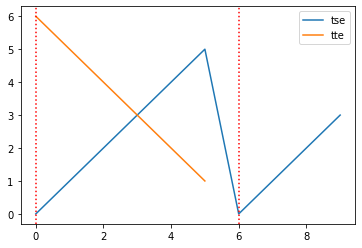

In [82]:
plt.plot(tse_l, label='tse')
plt.plot(tte_l, label='tte')
for t in arrt:
    plt.axvline(t, ls=':', color='red')
plt.legend()
plt.show()